In [1]:
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull
from time import time

torch.cuda.set_device(2)
print("Current Device: GPU {}".format(torch.cuda.current_device()))
print("Pytorch Version: {}".format(torch.__version__))

Current Device: GPU 2
Pytorch Version: 1.0.0


In [2]:
import numpy as np
# random hull
def reorder(v, e):
    e_list = [list(e[0])]
    e_finish = [0]

    for i in range(1, e.shape[0]):
        p = e_list[-1][-1]
        loc = np.stack(np.where(e == p), axis=-1)
        if loc[0, 0] in np.array(e_finish):
            l = 1
        else:
            l = 0
        e_finish.append(loc[l, 0])
        n = int(e[loc[l, 0]].sum()-p)
        e_list.append([p, n])

    return np.array(e_list)
        
def rand_hull(n_points, dim, hull=False, dtype=torch.float32):
    V = np.random.rand(n_points, dim)
    if not hull:
        mesh = Delaunay(V)
        E = mesh.simplices
    else:
        mesh = ConvexHull(V)
        E = mesh.simplices
        E = reorder(V, E)
    V, E = torch.tensor(V, dtype=dtype), torch.LongTensor(E)
    # normalize V to 
    V_bb = torch.max(V, dim=0)[0] - torch.min(V, dim=0)[0]
    V_c = (torch.max(V, dim=0)[0] + torch.min(V, dim=0)[0]) / 2
    V -= V_c
    V /= 1.5*V_bb
    V += 0.5
    return V, E

def plot_F(F):
    F = F.squeeze()
    if torch.sum(torch.isnan(F)) > 0:
        nnan = torch.sum(torch.isnan(F))
        F[torch.isnan(F)] = 0
        print("Padding {} nan terms to zero.".format(nnan))

    F_ = F.cpu().detach().numpy()
    f_ = torch.irfft(F, dim, signal_sizes=res).squeeze().cpu().detach().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(f_.T, origin='lower')

    plt.colorbar()
    plt.show()

In [3]:
## TODO: Check backwards for line mesh (j=1)

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from math import pi

from utils import fftfreqs, simplex_content, permute_seq, coalesce_update, img, construct_B_batch, batch_adjugate
from math import ceil, factorial

class SimplexFT(Function):
    """
    Fourier transform for signal defined on a j-simplex set in R^n space
    :param V: vertex tensor. float tensor of shape (n_vertex, n_dims)
    :param E: element tensor. int tensor of shape (n_elem, j or j+1)
              if j cols, triangulate/tetrahedronize interior first.
    :param D: int ndarray of shape (n_vertex, n_channel)
    :param res: n_dims int tuple of number of frequency modes
    :param t: n_dims tuple of period in each dimension
    :param j: dimension of simplex set
    :param mode: normalization mode.
                 'density' for preserving density, 'mass' for preserving mass
    :return: F: ndarray of shape (res[0], res[1], ..., res[-1]/2, n_channel)
                last dimension is halfed since the signal is assumed to be real
    """
    @staticmethod
    def forward(ctx, V, E, D, res, t, j, elem_batch=100, mode='density'):
        ## check if E is subdim
        subdim = E.shape[1] == j and V.shape[1] == j
        assert (E.shape[1] == j+1 or subdim)
        if subdim:
            assert((D == D[0]).sum().item() == D.numel()) # assert same densities for all simplices (homogeneous filling)
            V = torch.cat((V, torch.zeros(1, V.shape[1], device=V.device, dtype=V.dtype)), dim=0)
            E = torch.cat((E, V.shape[0] - 1 + torch.zeros((E.shape[0], 1), device=E.device, dtype=E.dtype)), dim=1)
        n_elem = E.shape[0]
        n_vert = V.shape[0]
        n_channel = D.shape[1]

        ## save context info for backwards
        ctx.mark_non_differentiable(E, D) # mark non-differentiable
        ctx.res = res
        ctx.t = t
        ctx.j = j
        ctx.mode = mode
        ctx.n_dims = V.shape[1]
        ctx.elem_batch = elem_batch
        ctx.subdim = subdim
        
        # compute content array
        C = factorial(j) * simplex_content(V, E, signed=subdim) # [n_elem, 1]
        ctx.save_for_backward(V, E, D, C)

        ## compute frequencies F
        n_dims = ctx.n_dims
        assert(n_dims == len(res))  # consistent spacial dimensionality
        assert(E.shape[0] == D.shape[0])  # consistent vertex numbers
        assert(mode in ['density', 'mass'])
        
        # frequency tensor
        omega = fftfreqs(res, dtype=V.dtype).to(V.device) # [dim0, dim1, dim2, d]

        # normalize frequencies
        for dim in range(n_dims):
            omega[..., dim] *= 2 * pi / t[dim]

        # initialize output F
        F_shape = list(omega.shape)[:-1]
        F_shape += [n_channel, 2]
        F = torch.zeros(*F_shape, dtype=V.dtype, device=V.device) # [dimX, dimY, dimZ, n_chan, 2] 2: real/imag

        # compute element-point tensor
        P = V[E] # [n_elem, j+1, d]

        # loop over element batches
        for idx in range(ceil(n_elem/elem_batch)):
            id_start = idx * elem_batch
            id_end = min((idx+1) * elem_batch, n_elem)
            Xi = P[id_start:id_end] # [elem_batch, j+1, d]
            Di = D[id_start:id_end] # [elem_batch, n_channel]
            Ci = C[id_start:id_end] # [elem_batch, 1]
            CDi = Ci * Di # [elem_batch, n_channel]
            sig = torch.einsum('bjd,...d->bj...', (Xi, omega)) 
            sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1]
            esig = torch.stack((torch.cos(sig), -torch.sin(sig)), dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
            sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
            denom = torch.ones_like(sig) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
            for dim in range(1, j+1):
                seq = permute_seq(dim, j+1)
                denom *= sig - sig[:, seq]
            tmp = torch.sum(esig / denom, dim=1) # [elem_batch, dimX, dimY, dimZ, 1, 2]
            CDi.unsqueeze_(-1) # [elem_batch, n_channel, 1]
            for _ in range(n_dims): # unsqueeze to broadcast
                CDi.unsqueeze_(dim=1) # [elem_batch, 1, 1, 1, n_channel, 1]
            tmp *= CDi # [elem_batch, dimX, dimY, dimZ, n_channel, 2]
            Fi = torch.sum(tmp, dim=0, keepdim=False) # [dimX, dimY, dimZ, n_channel, 2]
            Fi[tuple([0] * n_dims)] = - 1 / factorial(j) * torch.sum(CDi, dim=0).unsqueeze(dim=-1)
            F += Fi

        F = img(F, deg=j) # Fi *= 1j**j [dimX, dimY, dimZ, n_chan, 2] 2: real/imag

        if mode == 'density':
            res_t = torch.tensor(res)
            if not torch.equal(res_t, res[0]*torch.ones(len(res), dtype=res_t.dtype)):
                print("WARNING: density preserving mode not correctly implemented if not all res are equal")
            F *= res[0] ** j
        return F

    @staticmethod
    @once_differentiable
    def backward(ctx, dF):
        """
        :param dF: per-frequency sensitivity from downstream layers of shape [dimX, dimY, dimZ, n_channel, 2]
        """
        if ctx.needs_input_grad[0]:
            V, E, D, C = ctx.saved_tensors

            n_dims = V.shape[1]
            n_elem = E.shape[0]
            n_vert = V.shape[0]
            n_channel = D.shape[1]

            # recover context
            res = ctx.res
            t = ctx.t
            j = ctx.j
            mode = ctx.mode
            n_dims = ctx.n_dims
            elem_batch = ctx.elem_batch

            # frequency tensor
            omega = fftfreqs(res, dtype=V.dtype).to(V.device) # [dim0, dim1, dim2, d]

            # normalize frequencies
            for dim in range(n_dims):
                omega[..., dim] *= 2 * pi / t[dim]

            # compute element-point tensor
            P = V[E] # [n_elem, j+1, d]

            # initialize output dV
            dV = torch.zeros_like(V) # [j+1, n_dims]

            # compute element-point tensor
            P = V[E] # [n_elem, j+1, n_dims]

            # helper functions
            seq = lambda i : permute_seq(i, j+1) # return looped sequences

            # loop over element batches
            for idx in range(ceil(n_elem/elem_batch)):
                id_start = idx * elem_batch
                id_end = min((idx+1) * elem_batch, n_elem)
                elem_batch_i = id_end - id_start
                Xi = P[id_start:id_end] # [elem_batch, j+1, n_dims]
                Di = D[id_start:id_end] # [elem_batch, n_channel]
                Ci = C[id_start:id_end] # [elem_batch, 1]
                Ei = E[id_start:id_end] # [elem_batch, j+1]
                sig = torch.einsum('bjd,...d->bj...', (Xi, omega)) 
                sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1]
                esig = torch.stack((torch.cos(sig), -torch.sin(sig)), dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
                denom = torch.ones_like(sig) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
                for dim in range(1, j+1):
                    denom *= sig - sig[:, seq(dim)]
                Si = esig / denom # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                # first part: tmp
                tmp = torch.zeros_like(Si) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                for dim in range(1, j+1):
                    tmp += (Si[:, seq(dim)] + Si) / (sig[:, seq(dim)] - sig)
                tmp -= img(Si, deg=1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                tmp = tmp.permute(*(list(range(2, 2+n_dims)) + [0, 1] + list(range(2+n_dims, len(tmp.shape)))))
                tmp[tuple([0] * n_dims)] = 0
                tmp = tmp.permute(*(list(range(n_dims, 2+n_dims)) + list(range(n_dims)) + list(range(2+n_dims, len(tmp.shape)))))
                tmp *= dF # [elem_batch, j+1, dimX, dimY, dimZ, n_channel, 2]
                tmp = tmp.unsqueeze(-3) * omega.unsqueeze(-1).unsqueeze(-1) # [elem_batch, j+1, dimX, dimY, dimZ, n_dims, n_channel, 2]
                tmp = torch.sum(tmp, dim=tuple([-1]+list(range(2, 2+n_dims)))) # [elem_batch, j+1, n_dims, n_channel]
                tmp = torch.sum(tmp * Di.unsqueeze(1).unsqueeze(1), dim=3)     # [elem_batch, j+1, n_dims]
                tmp *= Ci.unsqueeze(-1) # [elem_batch, j+1, n_dims]
                
                # second part: tmp2
                S = torch.sum(Si, dim=1) # [elem_batch, dimX, dimY, dimZ, 1, 2]
                S = S.permute(*(list(range(1, 1+n_dims)) + [0] + list(range(1+n_dims, len(S.shape))))) # [dimX, dimY, dimZ, elem_batch, 1, 2]
                S[tuple([0] * n_dims)] = - 1 / factorial(j)
                S = S.permute(*([n_dims] + list(range(n_dims)) + list(range(1+n_dims, len(S.shape))))) # [elem_batch, dimX, dimY, dimZ, 1, 2]
                tmp2 = S * dF # [elem_batch, dimX, dimY, dimZ, n_channel, 2]
                tmp2 = torch.sum(tmp2, dim=tuple([-1] + list(range(1, 1+n_dims)))) # [elem_batch, n_channel]
                tmp2 *= ((-1)**(j+1)) / (2**j) 
                tmp2 /= Ci # [elem_batch, n_channel]
                tmp2 = (tmp2 * Di).sum(-1) # [elem_batch]
                # summation term
                B = construct_B_batch(Xi) # [elem_batch, j+2, j+2]
                B_adj = batch_adjugate(B) # [elem_batch, j+2, j+2]
                B_adj_sub = B_adj[:, 1:, 1:] # [elem_batch, j+1, j+1]
                tmpsum = torch.zeros_like(Xi) # [elem_batch, j+1, n_dims]
                rind = list(range(j+1))
                for dim in range(1, j+1):
                    adj = B_adj_sub[:, rind, seq(dim)].unsqueeze(-1) # [elem_batch, j+1, 1]
                    tmpsum += 2 * (Xi - Xi[:, seq(dim)]) * adj # [elem_batch, j+1, n_dims]
                tmp2 = tmpsum * tmp2.unsqueeze(-1).unsqueeze(-1)  # [elem_batch, j+1, n_dims]
                
                tmp += tmp2
                tmp = img(tmp, deg=j)
                ddV = coalesce_update(Ei, tmp, dV.shape)
                dV += ddV
                
            if mode == "density":
                dV *= res[0] ** j
                
        else:
            dV = None
            
        return dV, None, None, None, None, None, None, None

    
class DDSL(nn.Module):
    def __init__(self, res, t, j, elem_batch=100, mode='density'):
        super(DDSL, self).__init__()
        self.res = res
        self.t = t
        self.j = j
        self.elem_batch = elem_batch
        self.mode = mode
    def forward(self, V, E, D):
        return SimplexFT.apply(V,E,D,self.res,self.t,self.j,self.elem_batch,self.mode)
        

Number of Elements: 187
Forward Time Lapse: 0.019524097442626953
Backward Time Lapse: 0.06870746612548828


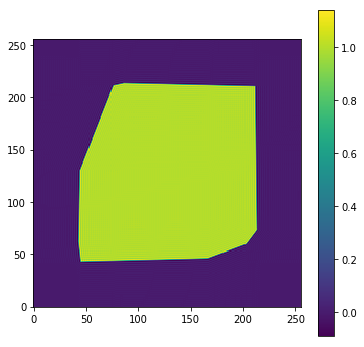

In [9]:
r = 256
j = 2
hull = j == 1
dim = 2
npt = 100

# Vertex matrix
V, E = rand_hull(npt, dim, hull=hull, dtype=torch.float64)
V, E = V.cuda(), E.cuda()
V += 1e-3 * torch.rand(V.shape, dtype=V.dtype, device=V.device)
if j == 0:
    E = torch.arange(V.shape[0], device=V.device).unsqueeze(-1)
D = torch.ones(E.shape[0], 1, dtype=V.dtype, device=V.device)
# D = torch.rand(E.shape[0], 1, dtype=V.dtype)
V.requires_grad = True

res = [r] * 2
t = [1] * 2

# Sensitivity on each frequency mode
dF = torch.ones(r, int(r/2)+1, 2, dtype=V.dtype) # unit sensitivity

ddsl = DDSL(res, t, j, elem_batch=100, mode='density')

t0 = time()
F = ddsl(V, E, D)
t1 = time()
print("Number of Elements: {}".format(E.shape[0]))
print("Forward Time Lapse: {}".format(t1 - t0))
torch.cuda.empty_cache()

# Backwards pass time
loss = F.view(-1).sum(0)
if V.grad is not None:
    V.grad.zero_()
t0 = time()
loss.backward()
t1 = time()
dV = V.grad
print("Backward Time Lapse: {}".format(t1 - t0))

# plot
plot_F(F)

## Setting up

In [5]:
r = 256
j = 1
hull = j == 1
dim = 2
npt = 20

# Vertex matrix
if npt < 3 and j == 0:
#     V = torch.rand(npt, dim)
#     E = torch.arange(V.shape[0], device=V.device).unsqueeze(-1)
    V = torch.tensor([[0.5, 0.5]], dtype=torch.float64)
    E = torch.LongTensor(3,1, device=V.device)
else:
    V, E = rand_hull(npt, dim, hull=hull, dtype=torch.float64)
V, E = V.cuda(), E.cuda()
V += 1e-3 * torch.rand(V.shape, dtype=V.dtype, device=V.device)
if j == 0:
    E = torch.arange(V.shape[0], device=V.device).unsqueeze(-1)
# D = torch.ones(E.shape[0], 1, dtype=V.dtype)
D = torch.rand(E.shape[0], 1, dtype=V.dtype)
V.requires_grad = True


res = [r] * 2
t = [1] * 2

E, D = E.cuda(), D.cuda()

# Sensitivity on each frequency mode
dF = torch.ones(r, int(r/2)+1, 1, 2, dtype=V.dtype) # unit sensitivity

## Test backward

Analytical Gradient:
tensor([[ 0.0000e+00,  0.0000e+00],
        [-9.9541e-02,  1.1519e+02],
        [-2.3545e+02, -2.4160e+03],
        [ 5.2437e+02, -1.4756e+04],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-3.7838e+01,  5.3150e+01],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-4.5998e+02, -5.8287e+03],
        [ 0.0000e+00,  0.0000e+00],
        [-3.3717e+02,  2.2407e+03],
        [ 0.0000e+00,  0.0000e+00]], device='cuda:2', dtype=torch.float64)
Finite Difference Gradient (New):
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 4.6467e+01, -7.3316e+00],
        [ 2.7223e+03, -2.1932e+02],
        [-9.8904e+03, -2.1087e+02],
        [ 0.0000e+00,  0.0000e+00],
      

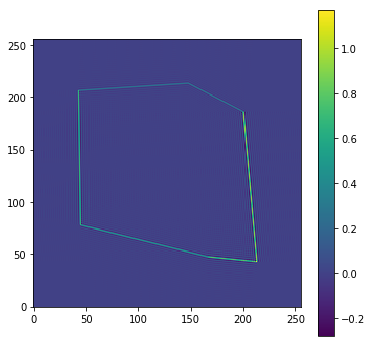

In [6]:
# Analytical Adjoint solution
ddsl = DDSL(res,t,j,100,'density')
F = ddsl(V,E,D)
loss = F.view(-1).sum(0)
if V.grad is not None:
    V.grad.zero_()
loss.backward()
dV = V.grad
print("Analytical Gradient:")
print(dV)

print("Finite Difference Gradient (New):")
# Finite difference approximation
delta = 1e-6
dV_fd_all = torch.zeros(*(list(V.shape)+list(dF.shape)), dtype=V.dtype).cuda()
for ii in range(V.shape[0]):
    for jj in range(V.shape[1]):
        V_p = V.clone()
        V_m = V.clone()
        V_p[ii, jj] += delta
        V_m[ii, jj] -= delta
        Freq_p = ddsl(V_p, E, D)
        Freq_m = ddsl(V_m, E, D)
        dV_fd_all[ii,jj] = (Freq_p - Freq_m) / delta / 2
dV_fd = dV_fd_all.view(V.shape[0], V.shape[1], -1).sum(-1)
print(dV_fd)
print(dV - dV_fd < 1e-3)
plot_F(F)